## Criando um modelo de classificacao pra definir a faixa etária de quem praticou o delito.

## 1- Importando a base de dados

In [1]:
#  Importando as bibliotecas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date

 - Link do site onde encontra-se o dataset
 
 url:https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc

In [2]:
df=pd.read_csv('dataset.csv')

In [3]:
# visualizando as 5 primeiras linhas do dataset
df[0:5]

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,222243929,12/25/2020,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,B,40,0,25-44,M,BLACK,1007453,233952,40.808798,-73.916184,POINT (-73.91618413199996 40.80879780500004)
1,222115778,12/22/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,M,33,0,18-24,M,BLACK HISPANIC,1001456,247485,40.845956,-73.937813,POINT (-73.93781267199995 40.84595574000008)
2,222090516,12/21/2020,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,Q,106,0,25-44,M,BLACK,1028605,187930,40.682398,-73.840079,POINT (-73.84007936899997 40.68239828900005)
3,221653577,12/10/2020,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,Q,103,0,18-24,M,BLACK,1039602,190480,40.689336,-73.800409,POINT (-73.80040882999998 40.68933550400004)
4,221599602,12/09/2020,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",113.0,FORGERY,PL 1702500,F,S,120,0,18-24,M,BLACK,949767,170539,40.634708,-74.124241,POINT (-74.12424111699994 40.634707811000055)


## 2- Preparaçao dos dados


 - Removendo as colunas que nao serão utilizadas 

In [4]:
dados=df.drop(['ARREST_KEY', 'PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE','ARREST_PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD','New Georeferenced Column'], axis=1)

In [5]:
#  Renomeando as colunas

dados.columns = ['data_da_ocorrencia','descricao_da_ofensa','nivel_da_ofensa','bairro'
                     ,'idade_do_infrator','sexo_do_infrator','raca_do_infrator','latitude','longitude']

In [6]:
# reorganizando os dados referentes a data 

def date_to_weekday(date):
    weekday_dict = {0:'Monday', 1:'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    date_time_obj = datetime.datetime.strptime(date, '%m/%d/%Y')
    return weekday_dict[date_time_obj.weekday()]

date = dados['data_da_ocorrencia'].str.split("/", n = 3, expand = True)
dados['ano'] = date[2].astype('int32')
dados['dia'] = date[1].astype('int32')
dados['mes'] = date[0].astype('int32')
dados['dia_da_semana'] = dados['data_da_ocorrencia'].apply(date_to_weekday)

# alterando os dados da coluna nivel_da_ofensa

new_nivel_da_ofensa = {'M': "contravencao", 'F': "crime", 'V': "violacao",'I':"outro" }
dados['nivel_da_ofensa'] = dados['nivel_da_ofensa'].map(new_nivel_da_ofensa)

# alterando os dados da coluna bairro

new_bairro = {'B': 'Bronx', 'S': 'Staten_Island', 'K': 'Brooklyn', 'M': 'Manhattan' , 'Q': 'Queens' }
dados['bairro'] = dados['bairro'].map(new_bairro)

In [7]:
dados.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,ano,dia,mes,dia_da_semana
0,12/25/2020,FELONY ASSAULT,crime,Bronx,25-44,M,BLACK,40.808798,-73.916184,2020,25,12,Friday
1,12/22/2020,ROBBERY,crime,Manhattan,18-24,M,BLACK HISPANIC,40.845956,-73.937813,2020,22,12,Tuesday
2,12/21/2020,FELONY ASSAULT,crime,Queens,25-44,M,BLACK,40.682398,-73.840079,2020,21,12,Monday
3,12/10/2020,FELONY ASSAULT,crime,Queens,18-24,M,BLACK,40.689336,-73.800409,2020,10,12,Thursday
4,12/09/2020,FORGERY,crime,Staten_Island,18-24,M,BLACK,40.634708,-74.124241,2020,9,12,Wednesday


 - Convertendo a coluna " DATA_DA_OCORRENCIA "para formato datetime

In [8]:
dados["data_da_ocorrencia"] = pd.to_datetime(dados["data_da_ocorrencia"] )

## 3.1 Preparação dos Dados para modelagem
- Separação Treino/Teste
- Separar Dados de Entrada (Atributos) e de saída (target)
- Tratar colunas categóricas
- Tratar dados ausentes


## Criando um modelo de classificacao pra definir a faixa etária de quem praticou o delito.

 - Selecionando apenas os delitos mais recorrentes

In [9]:
# dados = dados.query('descricao_da_ofensa =="ASSAULT 3 & RELATED OFFENSES" or  descricao_da_ofensa =="FELONY ASSAULT" or descricao_da_ofensa =="PETIT LARCENY" or descricao_da_ofensa =="DANGEROUS DRUGS" or descricao_da_ofensa =="MISCELLANEOUS PENAL LAW" or descricao_da_ofensa =="ROBBERY" or descricao_da_ofensa =="CRIMINAL MISCHIEF & RELATED OF" or descricao_da_ofensa =="BURGLARY" or  descricao_da_ofensa =="GRAND LARCENY" or descricao_da_ofensa =="DANGEROUS WEAPONS" or  descricao_da_ofensa =="OFFENSES AGAINST PUBLIC ADMINI" or descricao_da_ofensa =="VEHICLE AND TRAFFIC LAWS" or  descricao_da_ofensa =="OFF. AGNST PUB ORD SENSBLTY &" or descricao_da_ofensa =="SEX CRIMES" or descricao_da_ofensa =="INTOXICATED & IMPAIRED DRIVING"  ')

 - Verificando a exitência de dados ausentes>

In [10]:
dados.isna().sum()

data_da_ocorrencia        0
descricao_da_ofensa      37
nivel_da_ofensa        1389
bairro                    0
idade_do_infrator         0
sexo_do_infrator          0
raca_do_infrator          0
latitude                  0
longitude                 0
ano                       0
dia                       0
mes                       0
dia_da_semana             0
dtype: int64

In [11]:
dados = dados.dropna()

In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138987 entries, 0 to 140412
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   data_da_ocorrencia   138987 non-null  datetime64[ns]
 1   descricao_da_ofensa  138987 non-null  object        
 2   nivel_da_ofensa      138987 non-null  object        
 3   bairro               138987 non-null  object        
 4   idade_do_infrator    138987 non-null  object        
 5   sexo_do_infrator     138987 non-null  object        
 6   raca_do_infrator     138987 non-null  object        
 7   latitude             138987 non-null  float64       
 8   longitude            138987 non-null  float64       
 9   ano                  138987 non-null  int32         
 10  dia                  138987 non-null  int32         
 11  mes                  138987 non-null  int32         
 12  dia_da_semana        138987 non-null  object        
dtypes: datetime64[

 - Excluindo colunas que não serão utilizadas.
 
 Como todos os delitos são referentes ao ano de 2020 , iremos excluir apenas essa coluna.

In [13]:
dados = dados.drop(columns=['ano'])

 - Convertendo variáveis categóricas em variáveis numéricas

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
enconder = LabelEncoder()

In [16]:
dados['data_da_ocorrencia'] = enconder.fit_transform(dados['data_da_ocorrencia'])
dados['nivel_da_ofensa'] = enconder.fit_transform(dados['nivel_da_ofensa'])
dados['bairro'] = enconder.fit_transform(dados['bairro'])
dados['sexo_do_infrator'] = enconder.fit_transform(dados['sexo_do_infrator'])
dados['raca_do_infrator'] = enconder.fit_transform(dados['raca_do_infrator'])
dados['mes'] = enconder.fit_transform(dados['mes'])
dados['dia'] = enconder.fit_transform(dados['dia'])
dados['dia_da_semana'] = enconder.fit_transform(dados['dia_da_semana'])
dados['latitude'] = enconder.fit_transform(dados['latitude'])
dados['longitude'] = enconder.fit_transform(dados['longitude'])

In [17]:
dados.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,mes,dia_da_semana
0,359,FELONY ASSAULT,1,0,25-44,1,2,24042,16044,24,11,0
1,356,ROBBERY,1,2,18-24,1,3,27932,12432,21,11,5
2,355,FELONY ASSAULT,1,3,25-44,1,2,11085,25990,20,11,1
3,344,FELONY ASSAULT,1,3,18-24,1,2,12223,28212,9,11,4
4,343,FORGERY,1,4,18-24,1,2,4753,980,8,11,6


In [18]:
delitos= dados.descricao_da_ofensa.str.get_dummies()
delitos.head()

,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# dados['idade_do_infrator'] = enconder.fit_transform(dados['idade_do_infrator'])
# dados['descricao_da_ofensa'] = enconder.fit_transform(dados['descricao_da_ofensa'])

In [20]:
dados_delitos = pd.concat([dados, delitos], axis = 1)

In [21]:
dados_delitos.head()

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,359,FELONY ASSAULT,1,0,25-44,1,2,24042,16044,24,...,0,0,0,0,0,0,0,0,0,0
1,356,ROBBERY,1,2,18-24,1,3,27932,12432,21,...,0,0,0,0,1,0,0,0,0,0
2,355,FELONY ASSAULT,1,3,25-44,1,2,11085,25990,20,...,0,0,0,0,0,0,0,0,0,0
3,344,FELONY ASSAULT,1,3,18-24,1,2,12223,28212,9,...,0,0,0,0,0,0,0,0,0,0
4,343,FORGERY,1,4,18-24,1,2,4753,980,8,...,0,0,0,0,0,0,0,0,0,0


 - Reescalando os dados

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
delitos_escalados = scaler.fit_transform(delitos)

In [23]:
from sklearn.cluster import KMeans

In [24]:
modelo = KMeans(n_clusters = 5)
modelo.fit(delitos_escalados)

KMeans(n_clusters=5)

In [25]:
print(delitos.columns)
print(modelo.cluster_centers_)

Index(['ADMINISTRATIVE CODE', 'ADMINISTRATIVE CODES',
       'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'ALCOHOLIC BEVERAGE CONTROL LAW', 'ANTICIPATORY OFFENSES', 'ARSON',
       'ASSAULT 3 & RELATED OFFENSES', 'BURGLAR'S TOOLS', 'BURGLARY',
       'CHILD ABANDONMENT/NON SUPPORT', 'CRIMINAL MISCHIEF & RELATED OF',
       'CRIMINAL TRESPASS', 'DANGEROUS DRUGS', 'DANGEROUS WEAPONS',
       'DISORDERLY CONDUCT', 'ENDAN WELFARE INCOMP', 'ESCAPE 3',
       'FELONY ASSAULT', 'FORGERY', 'FRAUDS', 'FRAUDULENT ACCOSTING',
       'GAMBLING', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE',
       'HARRASSMENT 2', 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
       'HOMICIDE-NEGLIGENT-VEHICLE', 'INTOXICATED & IMPAIRED DRIVING',
       'INTOXICATED/IMPAIRED DRIVING', 'JOSTLING', 'KIDNAPPING',
       'KIDNAPPING & RELATED OFFENSES', 'KIDNAPPING AND RELATED OFFENSES',
       'LOITERING/GAMBLING (CARDS, DIC', 'MISCELLANEOUS PENAL LAW',
       'MOVING INFRACTIONS', 'MURDER & NON-NEGL. MANSLAUGHTE',
       

In [26]:
grupos = pd.DataFrame(modelo.cluster_centers_,
                     columns = delitos.columns)
grupos.head()

,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
0,-0.030123,-0.002682,-0.014195,-0.042873,-0.020782,-0.026427,-0.453760,-0.062627,-0.213442,-0.013142,...,3.344462,-0.115701,-0.058374,-0.064058,-0.246280,-0.141547,-0.030003,-0.031526,-0.061400,-0.184783
1,-0.030123,-0.002682,-0.014195,-0.042873,-0.020782,-0.026427,-0.453760,-0.062627,-0.213442,-0.013142,...,-0.299002,-0.115701,-0.058374,-0.064058,-0.246280,-0.141547,-0.030003,-0.031526,-0.061400,-0.184783
2,0.008691,0.000774,0.004096,0.012370,0.005996,0.007625,0.130922,0.018070,0.061584,0.003792,...,-0.299002,0.033383,0.016843,0.018483,0.071058,0.040840,0.008657,0.009096,0.017715,0.053315
3,-0.030123,-0.002682,-0.014195,-0.042873,-0.020782,-0.026427,-0.453760,-0.062627,-0.213442,-0.013142,...,-0.299002,-0.115701,-0.058374,-0.064058,-0.246280,-0.141547,-0.030003,-0.031526,-0.061400,-0.184783
4,-0.030123,-0.002682,-0.014195,-0.042873,-0.020782,-0.026427,-0.453760,-0.062627,-0.213442,-0.013142,...,-0.299002,-0.115701,-0.058374,-0.064058,-0.246280,-0.141547,-0.030003,-0.031526,-0.061400,-0.184783


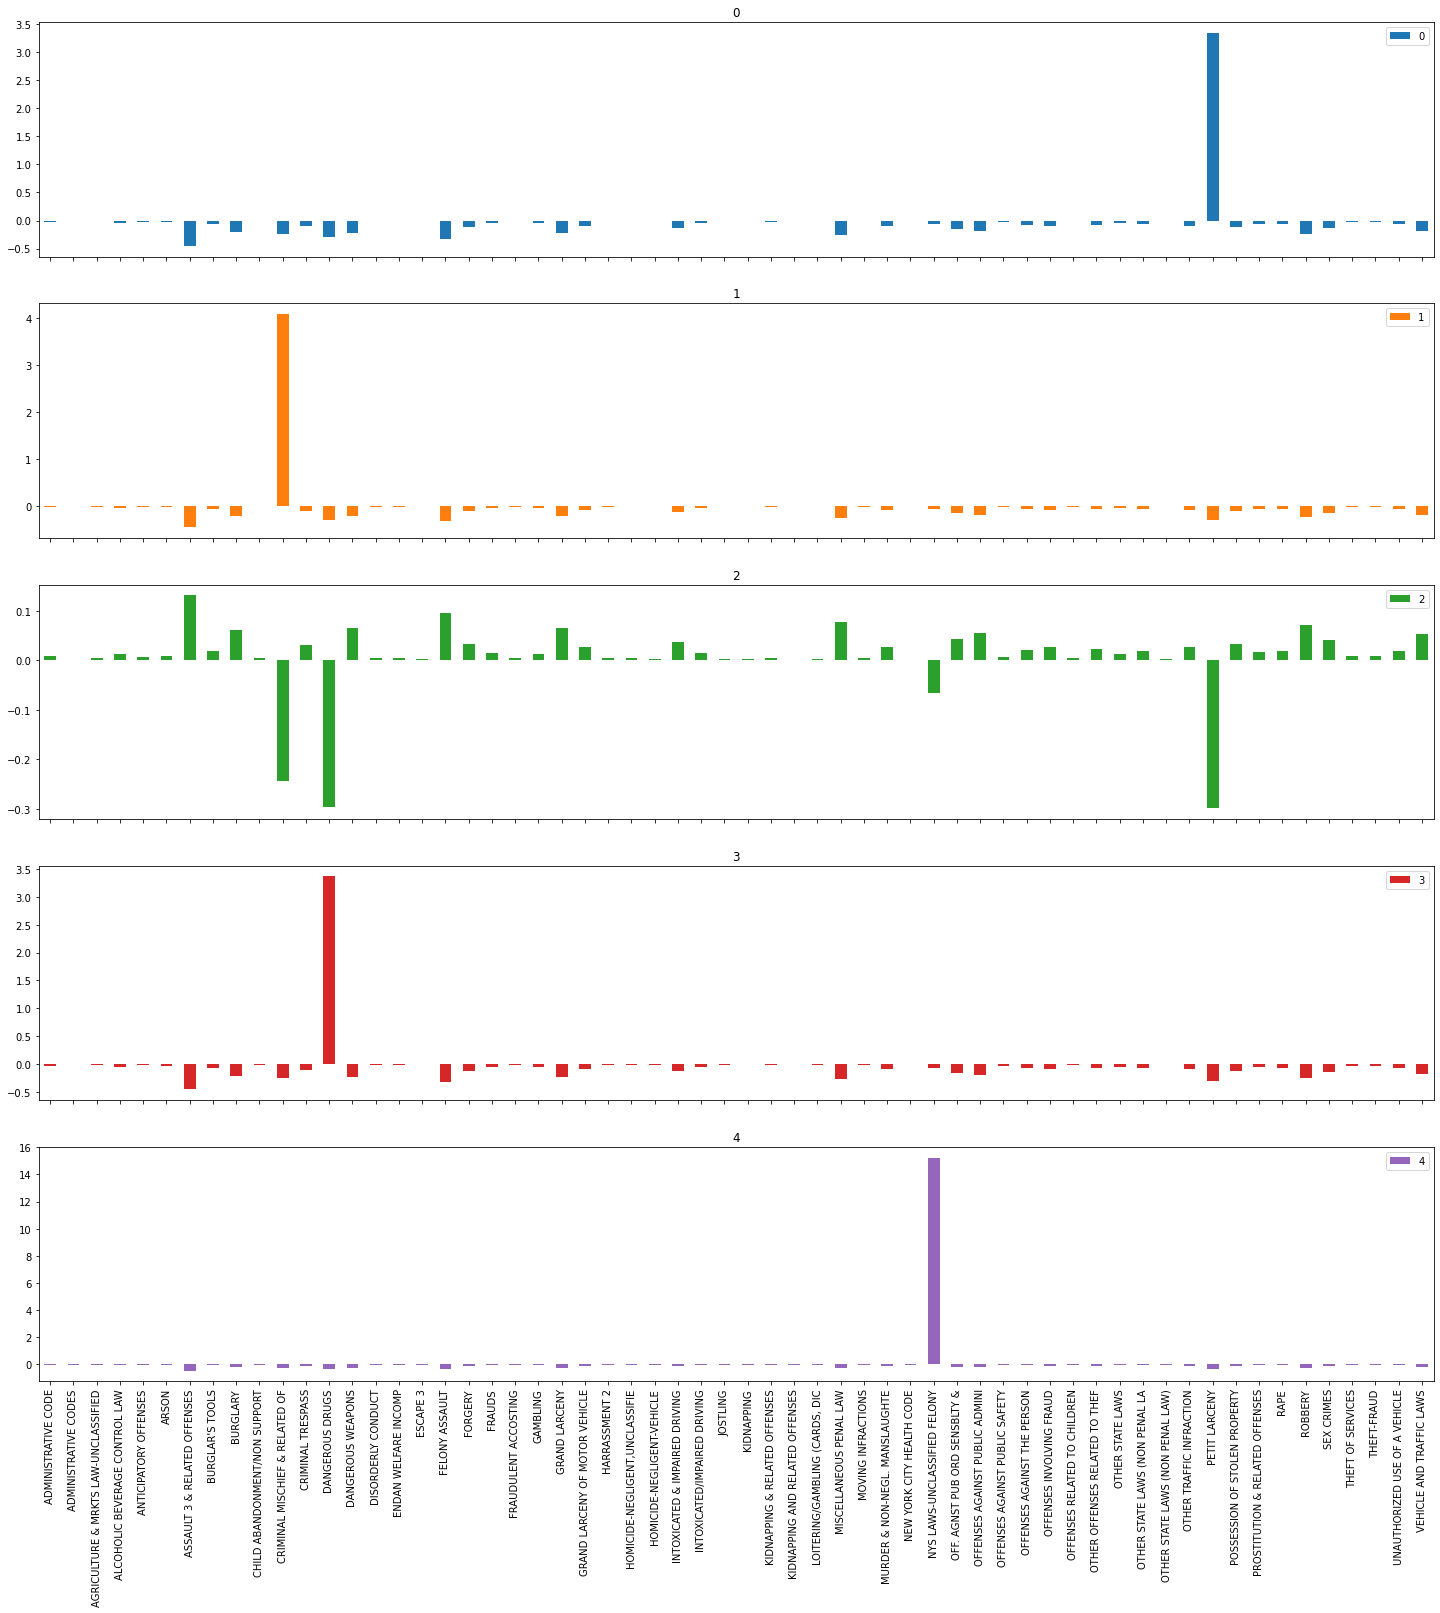

In [32]:
grupos.T.plot.bar(subplots = True,
              figsize = (25,25 ))
plt.xticks();
plt.show()

In [39]:
grupo = 4
filtro = modelo.labels_ == grupo
dados_delitos[filtro].sample(10)

,data_da_ocorrencia,descricao_da_ofensa,nivel_da_ofensa,bairro,idade_do_infrator,sexo_do_infrator,raca_do_infrator,latitude,longitude,dia,...,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,VEHICLE AND TRAFFIC LAWS
126253,47,NYS LAWS-UNCLASSIFIED FELONY,1,2,45-64,1,2,26221,12051,16,...,0,0,0,0,0,0,0,0,0,0
81770,132,NYS LAWS-UNCLASSIFIED FELONY,1,2,25-44,1,2,16246,3534,11,...,0,0,0,0,0,0,0,0,0,0
94781,61,NYS LAWS-UNCLASSIFIED FELONY,1,2,25-44,0,6,23722,10853,1,...,0,0,0,0,0,0,0,0,0,0
2439,319,NYS LAWS-UNCLASSIFIED FELONY,1,1,45-64,1,2,8644,19358,14,...,0,0,0,0,0,0,0,0,0,0
57161,238,NYS LAWS-UNCLASSIFIED FELONY,1,1,25-44,1,6,3700,3155,25,...,0,0,0,0,0,0,0,0,0,0
21655,324,NYS LAWS-UNCLASSIFIED FELONY,1,2,25-44,1,3,29503,15324,19,...,0,0,0,0,0,0,0,0,0,0
5937,344,NYS LAWS-UNCLASSIFIED FELONY,1,2,45-64,1,2,16157,3539,9,...,0,0,0,0,0,0,0,0,0,0
90929,63,NYS LAWS-UNCLASSIFIED FELONY,1,1,45-64,1,5,4543,2296,3,...,0,0,0,0,0,0,0,0,0,0
44000,269,NYS LAWS-UNCLASSIFIED FELONY,1,1,25-44,1,2,8400,19344,25,...,0,0,0,0,0,0,0,0,0,0
3019,316,NYS LAWS-UNCLASSIFIED FELONY,1,0,25-44,1,6,25079,23401,11,...,0,0,0,0,0,0,0,0,0,0


- Utilizando um algoritmo pra reduzir o número de dimensões e facilitar a visualização.

In [40]:
from sklearn.manifold import TSNE

In [41]:
tsne = TSNE()

In [ ]:
visualizacao =  tsne.fit_transform(delitos_escalados)

In [ ]:
visualizacao

In [ ]:
sns.set(rc={'figure.figsize':(13,10)})

sns.scatterplot(x = visualizacao[:, 0],
               y = visualizacao[:, 1],
               hue = modelo.labels_,
               palette = sns.color_palette('Set1',5))

In [ ]:
# Criando uma função para calcular o erro de acordo com o número de clusters.

def kmeans(numero_de_clusters, delitos):
    modelo = KMeans(n_clusters = numero_de_clusters)
    modelo.fit(delitos)
    return [numero_de_clusters, modelo.inertia_]

In [ ]:
kmeans(15,delitos_escalados)

In [ ]:
resultado = [kmeans(numero_de_grupos, delitos_escalados) for numero_de_grupos in range(1,20 )]

In [ ]:
resultado = pd.DataFrame( resultado,
            columns=['grupos','inertia'])

In [ ]:
resultado.inertia.plot(xticks=resultado.grupos)